# Práctica Final Large Language Models

## Autor: Manuel Pérez Perdomo.

## 1. Configuración del entorno y API Keys.

In [28]:
# --- GESTIÓN DE CREDENCIALES ---
import os, getpass
from dotenv import load_dotenv

# Carga variables desde un archivo .env si existe
dotenv_loaded = load_dotenv()

api_key_names = {
    "OpenAI API key": "OPENAI_API_KEY", # (Opcional si solo usas Gemini)
    "Google Gemini API key": "GOOGLE_API_KEY", # Para el LLM y Embeddings
    "LangSmith API key": "LANGSMITH_API_KEY",  # Para trazas y monitoreo
    "Tavily API key": "TAVILY_API_KEY",        # Para búsqueda web
}

# Solicita interactivamente las claves que falten para no escribirlas en texto plano
for key, value in api_key_names.items():
    if not os.getenv(value):
        os.environ[value] = getpass.getpass(f"🔑 {key}: ")
    
    # Validación final
    if not os.getenv(value):
        raise RuntimeError(f"❌ Falta la API key '{value}'.")

print("✅ Claves cargadas correctamente.")



✅ Claves cargadas correctamente.


## 2. Inicialización de Herramientas Externas (Búsqueda Web)

In [29]:
# --- HERRAMIENTA DE BÚSQUEDA WEB ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Inicializamos el buscador Tavily limitando a 2 resultados para optimizar tokens
search = TavilySearchResults(max_results=2)

# Prueba unitaria de la herramienta para asegurar conexión
# search_results = search.invoke("¿Qué tiempo hace en Tenerife, Canarias?")
# print(search_results)

tools = [search] # Lista base de herramientas

## 3. Pipeline RAG: Carga e Indexación de datos (PDF)

In [30]:
# --- CARGA Y PREPARACIÓN DE DATOS (RAG) ---
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

# 1. Cargar el documento PDF (Guía de Tenerife)
loader = PyPDFLoader("data/Tenerife.pdf")
docs = loader.load()

# 2. Fragmentación (Splitting)
# Dividimos el texto en trozos de 1000 caracteres con solapamiento
# Esto es necesario porque el LLM tiene límite de contexto y mejora la precisión
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

# 3. Embeddings (Vectorización)
# Convertimos el texto a vectores numéricos usando el modelo de Google
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# 4. Base de Datos Vectorial
# Almacenamos los vectores en memoria para búsquedas rápidas de similitud
vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(documents=all_splits)

INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/embedding-001:batchEmbedContents "HTTP/1.1 200 OK"


['68b868d6-2fa8-4f01-86d5-a25980881e03',
 '81c4905c-808e-47e5-9ce6-fbe0a0e292c2',
 'dc20da87-91ed-41d0-94ff-4277825b08a2',
 '71f61ff1-9080-4e1e-9186-c74c3dc1065c',
 'de19c952-701b-48ea-9ec2-78b0d39f632f',
 'f08225eb-0e52-4d5b-938a-d4043968c0d1',
 '38efedc4-a6aa-4dd7-b41c-2fce26ef1ec4',
 'd07f245f-9da8-443f-8e67-787197cd694d',
 '29a70f6a-d225-46f9-970d-4cd30a9c3d92',
 '575fafb4-b53b-402e-910e-8fc0957161ec',
 'eb5860ec-2175-4603-b012-45608c233e07',
 '10067c75-bd40-4b3f-b5b9-59c834b55546',
 'adae9f1c-d730-4bbb-8927-f645f1d94cec',
 '2373f221-3721-4351-96a2-7e483441ae52',
 'b947e86d-df31-4654-9b79-abc323e920af',
 '95264b6d-ca3f-4550-afde-3120760d1e8a',
 '6e728d10-b284-49c1-8c07-f70f17f904dc',
 'c38d20e9-94dd-4fb0-81cb-c231d4d5d687',
 '20f427ec-12e2-4712-b624-3e2b9a063ec1',
 'e0f5b3b5-28d8-4698-a9e2-0a6f6420bee3',
 '6eb88030-a6c9-4f5a-a653-493896db275c',
 '3b587516-7bdb-488b-9283-b6d8024171cb',
 'cac097ea-25ea-44d1-a845-1ec8d51096f9',
 'c0c4335f-8470-4b20-bf2d-81cc6a49a55f',
 '00775445-9d3b-

## 4. Configuración del LLM y Grafo de Estado.

In [31]:
# --- CONFIGURACIÓN DEL MODELO Y GRAFO ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState, StateGraph

# 1. Instanciamos el LLM (Gemini 2.0 Flash)
# temperature=0.3: Creatividad baja para ser preciso como guía turística
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.3,
    max_output_tokens=1024,
    top_p=0.8
)

# 2. Inicializamos el constructor del grafo
# MessagesState gestiona el historial de la conversación automáticamente
graph_builder = StateGraph(MessagesState)

## 5. Definición de Herramientas Personalizadas (RAG y Clima).

In [32]:
# --- DEFINICIÓN DE HERRAMIENTAS (TOOLS) ---
from langchain_core.tools import tool
from pydantic import BaseModel, Field
import logging

# Configuración de logs para depurar el uso de herramientas
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("tenerife_bot")

# HERRAMIENTA 1: RAG (Recuperación de información del PDF)
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Recupera información turística e histórica de la guía PDF interna."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    # Serializamos la respuesta para el LLM
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}") for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# HERRAMIENTA 2: CLIMA (Con esquema Pydantic)
# Pydantic asegura que el LLM extraiga el nombre de la ciudad correctamente
class WeatherInput(BaseModel):
    city: str = Field(description="Ciudad de Tenerife a consultar, ej: 'Garachico'")

@tool("get_weather", args_schema=WeatherInput)
def get_weather(city: str):
    """Consulta el clima actual utilizando búsqueda web interna."""
    logger.info(f"TOOLS: Consultando clima para {city}")
    try:
        # El agente reutiliza la herramienta de búsqueda 'search' definida antes
        result = search.invoke(f"clima actual en {city} tenerife")
        return f"Datos del clima: {result}"
    except Exception as e:
        return "Error obteniendo clima."

## 6. Construcción y Compilación del Grafo

In [33]:
# --- ORQUESTACIÓN DEL AGENTE (LANGGRAPH) ---
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage

# 1. Lista maestra de herramientas disponibles para el agente
tools_list = [retrieve, get_weather, search]

# 2. Vinculación: El LLM ahora "conoce" estas herramientas
llm_with_tools = llm.bind_tools(tools_list)

# 3. Prompt del Sistema (Persona)
sys_msg = SystemMessage(content=(
    "Eres un guía turístico experto en Tenerife. Tono: amable y comercial. "
    "Usa 'retrieve' para datos históricos/lugares del PDF. "
    "Usa 'get_weather' para el tiempo. Se conciso."
))

# 4. Nodo Razonador (Toma de decisiones)
def reasoner(state: MessagesState):
    messages = state["messages"]
    # Aseguramos que el mensaje de sistema esté siempre presente
    if not isinstance(messages[0], SystemMessage):
        messages = [sys_msg] + messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 5. Nodo de Herramientas (Ejecución automática)
tool_node = ToolNode(tools_list)

# 6. Definición del Flujo del Grafo
builder = StateGraph(MessagesState)
builder.add_node("reasoner", reasoner)
builder.add_node("tools", tool_node)

builder.set_entry_point("reasoner") # Inicio: El agente piensa

# Lógica condicional: Si el LLM pide usar herramienta -> 'tools', si responde -> END
builder.add_conditional_edges("reasoner", tools_condition)
builder.add_edge("tools", "reasoner") # Ciclo: Tras usar herramienta, volver a pensar

# 7. Memoria (Persistencia entre turnos)
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


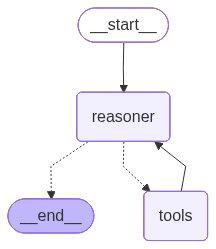

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 7. Ejecución de la conversación.

### Lugares Famosos del norte de Tenerife.

In [35]:
# Simulación de conversación
config = {"configurable": {"thread_id": "usuario_prueba_1"}}

print("--- Turno 1: Pregunta RAG ---")
inputs = {"messages": [("user", "Recomiéndame lugares famosos en el norte de Tenerife")]}

# Usamos stream para ver paso a paso
for step in graph.stream(inputs, config=config, stream_mode="values"):
    step["messages"][-1].pretty_print()

print("\n--- Turno 2: Pregunta Clima (Debe recordar contexto y usar tool nueva) ---")
# Como usamos el mismo thread_id, recuerda lo anterior
inputs_2 = {"messages": [("user", "¿Y qué tiempo hace hoy en alguno de esos lugares?")]}

for step in graph.stream(inputs_2, config=config, stream_mode="values"):
    step["messages"][-1].pretty_print()

--- Turno 1: Pregunta RAG ---
================================ Human Message =================================

Recomiéndame lugares famosos en el norte de Tenerife


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 429 Too Many Requests"
INFO:google_genai._api_client:Retrying google.genai._api_client.BaseApiClient._request_once in 1.766274395061211 seconds as it raised ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.', 'status': 'RESOURCE_EXHAUSTED'}}.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 429 Too Many Requests"
INFO:google_genai._api_client:Retrying google.genai._api_client.BaseApiClient._request_once in 2.924625957772025 seconds as it raised ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/gene

================================== Ai Message ==================================

¡Hola! ¡Claro que sí! El norte de Tenerife es precioso. Para recomendarte lugares famosos, necesito saber qué tipo de cosas te interesan. ¿Te gustan más los pueblos con encanto, la naturaleza, la historia...?

Mientras tanto, puedo recomendarte algunos lugares que suelen gustar mucho:

*   **La Orotava:** Un pueblo con una arquitectura tradicional canaria preciosa y jardines espectaculares.
*   **Puerto de la Cruz:** Una ciudad costera con mucha vida, playas y el famoso Lago Martiánez.
*   **Garachico:** Un pueblo con piscinas naturales formadas por la lava volcánica.

Dime qué te interesa más y te daré recomendaciones más personalizadas. ¡Estoy aquí para ayudarte a planificar tu viaje perfecto!

--- Turno 2: Pregunta Clima (Debe recordar contexto y usar tool nueva) ---
================================ Human Message =================================

¿Y qué tiempo hace hoy en alguno de esos lugares?


INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 429 Too Many Requests"
INFO:google_genai._api_client:Retrying google.genai._api_client.BaseApiClient._request_once in 1.3769798053355093 seconds as it raised ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.', 'status': 'RESOURCE_EXHAUSTED'}}.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
INFO:tenerife_bot:TOOLS: Consultando clima para Garachico


================================== Ai Message ==================================

¡Por supuesto! Voy a consultar el tiempo en Garachico.
Tool Calls:
  get_weather (4b8d8e70-4eb7-461e-a044-ac45e4779e27)
 Call ID: 4b8d8e70-4eb7-461e-a044-ac45e4779e27
  Args:
    city: Garachico
================================= Tool Message =================================
Name: get_weather

Datos del clima: [{'title': 'Clima en Garachico hoy y pronóstico del tiempo a 14 días', 'url': 'https://www.clima.com/espana/canarias/garachico', 'content': 'Es noticia:\n\n Tormenta\n Lluvia\n Rayo\n Tornado\n Humedad\n Viento\n Hidrosfera\n Sensación térmica\n Meteoro\n Ola de calor\n Equinoccio\n Capa de ozono\n Aire\n Albedo\n\n# Clima en Garachico\n\nTenerife provincia\n\nImprimir ficha\n\nViento\n\n10  km/h\n\nSensación\n\n15°\n\nNubes\n\n17%\n\nRadiación UV\n\nBaja\n\nHumedad\n\n42%\n\nPresión\n\n1024 hPa\n\n ## Días\n ## Horas\n ## Fin de semana [...] | Lluvia | 0 mm | 0 mm | 0.3 mm | 3 mm | 0 mm | 0 mm | 0 

INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"


================================== Ai Message ==================================

En Garachico, la sensación térmica es de 15°C, con vientos de 10 km/h y 17% de nubes. La humedad es del 42% y la radiación UV es baja.


### Gráfica de la temperatura de los municipios de Tenerife.

INFO:tenerife_bot:TOOLS: Consultando clima para Santa Cruz de Tenerife


--- El Agente está consultando y extrayendo temperaturas ---


INFO:google_genai.models:AFC is enabled with max remote calls: 10.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 429 Too Many Requests"
INFO:google_genai._api_client:Retrying google.genai._api_client.BaseApiClient._request_once in 1.1179000524347957 seconds as it raised ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.', 'status': 'RESOURCE_EXHAUSTED'}}.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
INFO:tenerife_bot:TOOLS: Consultando clima para San Cristóbal de La Laguna


Santa Cruz de Tenerife: 17


INFO:google_genai.models:AFC is enabled with max remote calls: 10.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
INFO:tenerife_bot:TOOLS: Consultando clima para Puerto de la Cruz


San Cristóbal de La Laguna: 14


INFO:google_genai.models:AFC is enabled with max remote calls: 10.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
INFO:tenerife_bot:TOOLS: Consultando clima para Adeje


Puerto de la Cruz: 16


INFO:google_genai.models:AFC is enabled with max remote calls: 10.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 429 Too Many Requests"
INFO:google_genai._api_client:Retrying google.genai._api_client.BaseApiClient._request_once in 1.0868878828782917 seconds as it raised ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.', 'status': 'RESOURCE_EXHAUSTED'}}.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
INFO:tenerife_bot:TOOLS: Consultando clima para Arona


Adeje: 17


INFO:google_genai.models:AFC is enabled with max remote calls: 10.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 429 Too Many Requests"
INFO:google_genai._api_client:Retrying google.genai._api_client.BaseApiClient._request_once in 1.695703928567943 seconds as it raised ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.', 'status': 'RESOURCE_EXHAUSTED'}}.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
INFO:tenerife_bot:TOOLS: Consultando clima para Candelaria


Arona: 16


INFO:google_genai.models:AFC is enabled with max remote calls: 10.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
INFO:tenerife_bot:TOOLS: Consultando clima para Garachico


Candelaria: 17


INFO:google_genai.models:AFC is enabled with max remote calls: 10.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
INFO:tenerife_bot:TOOLS: Consultando clima para Icod de los Vinos


Garachico: 19


INFO:google_genai.models:AFC is enabled with max remote calls: 10.
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"


Icod de los Vinos: 16


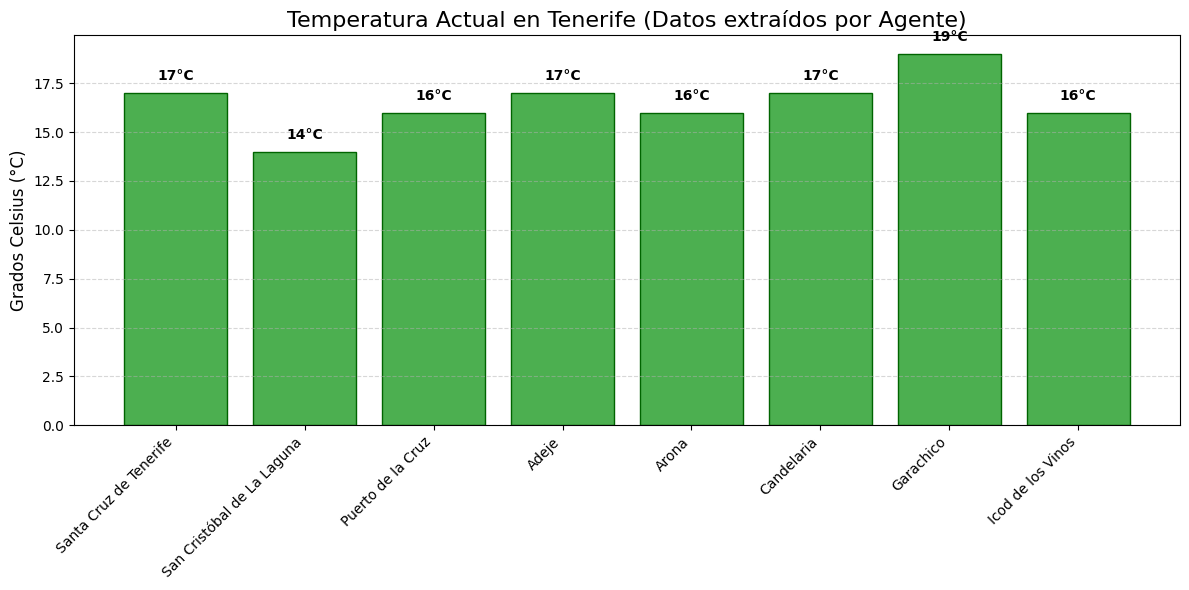

In [37]:
import matplotlib.pyplot as plt

# 1. Definimos los municipios
municipios = [
    "Santa Cruz de Tenerife", "San Cristóbal de La Laguna", 
    "Puerto de la Cruz", "Adeje", "Arona", 
    "Candelaria", "Garachico", "Icod de los Vinos"
]

datos_grafico = []

print("--- El Agente está consultando y extrayendo temperaturas ---")

for municipio in municipios:
    try:
        # PASO A: Usar la herramienta definida 'get_weather'
        raw_weather_data = get_weather.invoke({"city": municipio})
        
        # PASO B: Usar el LLM para "limpiar" el dato (Extracción)
        prompt_extraccion = (
            f"Analiza la siguiente información meteorológica de {municipio} y extrae "
            "ÚNICAMENTE el número de la temperatura actual en grados Celsius. "
            "Si hay un rango, calcula el promedio. No escribas texto, solo el número entero.\n\n"
            f"Información: {raw_weather_data}"
        )
        
        response = llm.invoke(prompt_extraccion)
        temp_str = response.content.strip()
        
        # Convertimos a entero para graficar
        if temp_str.replace('.', '', 1).isdigit():
            temp = int(float(temp_str))
            datos_grafico.append((municipio, temp))
            print(f"{municipio}: {temp}")
        else:
            print(f" El LLM no encontró una temperatura clara para {municipio}. Respuesta: {temp_str}")

    except Exception as e:
        print(f"Error procesando {municipio}: {e}")

# PASO C: Generamos el gráfico
if datos_grafico:
    ciudades, temps = zip(*datos_grafico) # Separamos en dos listas
    
    plt.figure(figsize=(12, 6))
    barras = plt.bar(ciudades, temps, color='#4CAF50', edgecolor='darkgreen')
    
    plt.title('Temperatura Actual en Tenerife (Datos extraídos por Agente)', fontsize=16)
    plt.ylabel('Grados Celsius (°C)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Etiquetas de valor
    for barra in barras:
        height = barra.get_height()
        plt.text(barra.get_x() + barra.get_width()/2., height + 0.5,
                 f'{height}°C', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvieron datos para graficar.")